In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tabulate import tabulate
import os

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("plots", exist_ok=True)

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        input = torch.cat([x, t], dim=1)
        for i in range(len(self.layers)-1):
            input = self.activation(self.layers[i](input))
        return self.layers[-1](input)

In [12]:
def pde_residual(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]

    return u_t - (1/16) * u_xx

In [13]:
# Generate Training Data
def generate_data():
    x_f = torch.rand(10000, 1, device=device) * 4.0
    t_f = torch.rand(10000, 1, device=device)

    x_i = torch.linspace(0, 4, 100).view(-1, 1).to(device)
    t_i = torch.zeros_like(x_i)
    u_i = 0.5 * x_i * (8 - x_i)

    t_b = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    x_b0 = torch.zeros_like(t_b)
    x_b1 = 4 * torch.ones_like(t_b)
    u_b0 = torch.zeros_like(t_b)
    u_b1 = 8 * torch.ones_like(t_b)

    return x_f, t_f, x_i, t_i, u_i, x_b0, x_b1, t_b, u_b0, u_b1

In [14]:
# Train the PINN
def train(model, optimizer, epochs=5000):
    loss_history = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()

        f = pde_residual(model, x_f, t_f)
        loss_f = torch.mean(f**2)

        u_pred_i = model(x_i, t_i)
        loss_i = torch.mean((u_pred_i - u_i)**2)

        loss_b = torch.mean((model(x_b0, t_b) - u_b0)**2) + torch.mean((model(x_b1, t_b) - u_b1)**2)

        loss = loss_f + loss_i + loss_b
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
    return loss_history

In [15]:
# Analytical Solution
N_terms = 100

def compute_Bn(n):
    integrand = lambda x: (-0.5 * x**2 + 2 * x) * np.sin(n * np.pi * x / 4)
    result, _ = quad(integrand, 0, 4)
    return 0.5 * result

B = [compute_Bn(n) for n in range(1, N_terms + 1)]

def v_xt(x, t):
    total = 0
    for n in range(1, N_terms + 1):
        lambda_n = (n * np.pi / 4)**2 / 16
        total += B[n - 1] * np.sin(n * np.pi * x / 4) * np.exp(-lambda_n * t)
    return total

def exact_u(x, t):
    return v_xt(x, t) + 2 * x

In [16]:
def compare_with_exact(model):
    x_vals = np.linspace(0, 4, 9)  # 0, 0.5, ..., 4
    t_vals = [0.0, 0.25, 0.5, 0.75, 1.0]

    comparison_rows = []
    model.eval()

    for t_val in t_vals:
        for x_val in x_vals:
            x_tensor = torch.tensor([[x_val]], dtype=torch.float32).to(device)
            t_tensor = torch.tensor([[t_val]], dtype=torch.float32).to(device)
            u_pinn = model(x_tensor, t_tensor).item()
            u_true = exact_u(x_val, t_val)
            abs_err = abs(u_pinn - u_true)
            comparison_rows.append([
                f"{x_val:.2f}", f"{t_val:.2f}",
                f"{u_pinn:.6f}", f"{u_true:.6f}", f"{abs_err:.2e}"
            ])

    print("\n📊 Comparison Table (x, t, PINN, Exact, |Error|):\n")
    print(tabulate(comparison_rows, headers=["x", "t", "PINN", "Exact", "Abs Error"], tablefmt="grid"))

In [17]:
def plot_solution_vs_exact(model):
    x_plot = np.linspace(0, 4, 200)
    x_tensor = torch.tensor(x_plot, dtype=torch.float32).view(-1, 1).to(device)
    t_vals = [0.0, 0.25, 0.5, 0.75, 1.0]

    plt.figure(figsize=(10, 6))
    for t_val in t_vals:
        t_tensor = torch.full_like(x_tensor, t_val)
        u_pinn = model(x_tensor, t_tensor).detach().cpu().numpy().flatten()
        u_exact = np.array([exact_u(xi, t_val) for xi in x_plot])

        plt.plot(x_plot, u_pinn, '--', label=f"PINN t={t_val}")
        plt.plot(x_plot, u_exact, '-', label=f"Exact t={t_val}")

    plt.title("PINN vs Exact Solution of 1D Heat Equation")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plots/pinn_vs_exact_comparison.png")
    plt.show()

Epoch 0: Loss = 104.776436
Epoch 500: Loss = 0.007643
Epoch 1000: Loss = 0.002631
Epoch 1500: Loss = 0.001781
Epoch 2000: Loss = 0.001382
Epoch 2500: Loss = 0.001073
Epoch 3000: Loss = 0.000835
Epoch 3500: Loss = 0.000660
Epoch 4000: Loss = 0.000529
Epoch 4500: Loss = 0.000430

📊 Comparison Table (x, t, PINN, Exact, |Error|):

+-----+------+-----------+---------+-------------+
|   x |    t |      PINN |   Exact |   Abs Error |
+=====+======+===========+=========+=============+
| 0   | 0    |  0.004913 | 0       |    0.00491  |
+-----+------+-----------+---------+-------------+
| 0.5 | 0    |  1.87337  | 1.875   |    0.00163  |
+-----+------+-----------+---------+-------------+
| 1   | 0    |  3.50344  | 3.5     |    0.00344  |
+-----+------+-----------+---------+-------------+
| 1.5 | 0    |  4.87027  | 4.875   |    0.00473  |
+-----+------+-----------+---------+-------------+
| 2   | 0    |  5.99837  | 6       |    0.00163  |
+-----+------+-----------+---------+-------------+
| 2.5 | 

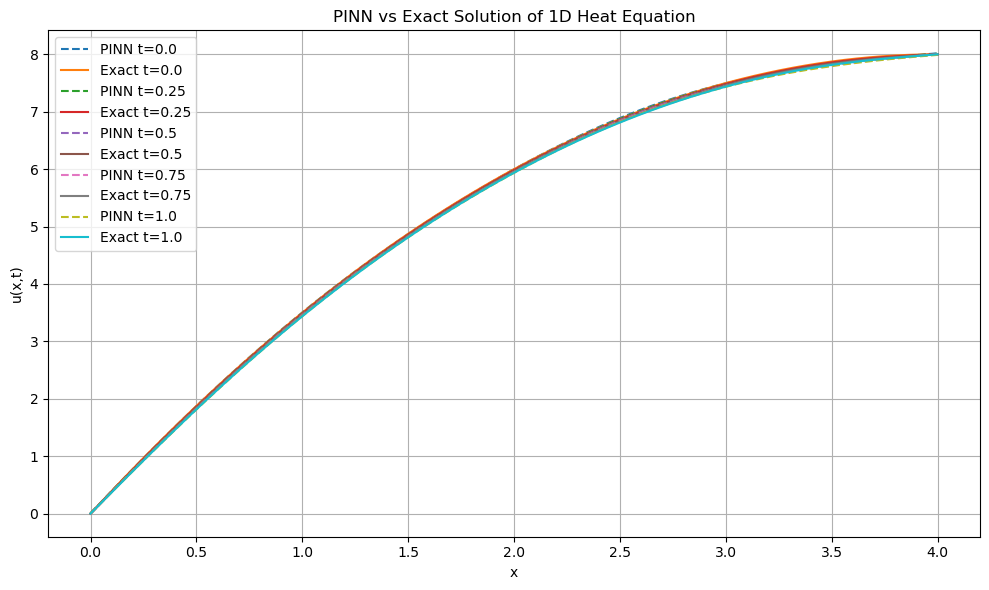

In [18]:
model = PINN([2, 64, 64, 64, 1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
x_f, t_f, x_i, t_i, u_i, x_b0, x_b1, t_b, u_b0, u_b1 = generate_data()

loss_history = train(model, optimizer, epochs=5000)

# Compare and plot
compare_with_exact(model)
plot_solution_vs_exact(model)

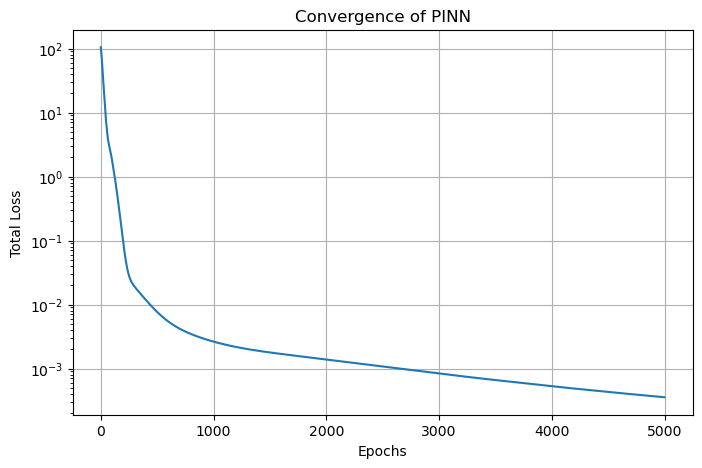

In [20]:
#Convergence Analysis (Loss vs Epochs)
plt.figure(figsize=(8, 5))
plt.plot(range(len(loss_history)), loss_history)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Convergence of PINN")
plt.grid(True)
plt.show()